In [1]:
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from pathlib import Path
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import random
import math
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from bokeh.plotting import figure 
from bokeh.io import output_notebook, show

# from datetime import date
# from random import randint
from bokeh.models import ColumnDataSource, HoverTool, Panel, Tabs
from bokeh.models.widgets import DataTable, DateFormatter, TableColumn, Dropdown, MultiSelect

# For DB scan
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

In [2]:
output_notebook()

Loading BokehJS ...

In [3]:
FOLDER_NAME = '2'
file_name = r'tracking.prqt'
root = r'D:\Users\avitu\Downloads\parquets'
_path = Path(root)/ FOLDER_NAME/ file_name
path = str(_path)
path

'D:\\Users\\avitu\\Downloads\\parquets\\2\\tracking.prqt'

In [4]:
data_set = pq.ParquetDataset(str(path),)
parquet = data_set.read()

In [5]:
df_raw = parquet.to_pandas()
print(len(df_raw))

21002


In [6]:
df = df_raw.copy()

#### Add previous point

In [7]:
def add_prev(df_id):
    df_prevs = df_id[['x','y',]].shift()
    df_ret =  df_id.join(df_prevs, rsuffix='_prev')
    
    angle = df_ret.apply(lambda row:  np.rad2deg(math.atan2(row.y-row.y_prev, row.x-row.x_prev)),axis=1)
    df_ret.loc[:,'angle'] = (angle +360) %360 
    
    df_prevs_angle = df_ret[['angle']].shift()
    df_ret =  df_ret.join(df_prevs_angle, rsuffix='_prev').reset_index(drop=True)
    
    angle_diff_1 = (df_ret.angle_prev - df_ret.angle +360) %360 
    angle_diff_2 = (df_ret.angle - df_ret.angle_prev +360) %360 
    
    angle_diff = pd.DataFrame(data=[angle_diff_1.values, angle_diff_2.values]).T.min(axis=1)
    df_ret.loc[:,'angle_diff'] = angle_diff   
 
    
    return df_ret

df = df.groupby('id').apply(add_prev).reset_index(drop=True)
df.tail()

,id,frame,x,y,w,h,label,x_prev,y_prev,angle,angle_prev,angle_diff
20997,357,9670,316,240,37,19,car,340.0,228.0,153.434949,225.000000,71.565051
20998,357,9671,304,242,37,19,car,316.0,240.0,170.537678,153.434949,17.102729
20999,357,9672,302,243,37,19,car,304.0,242.0,153.434949,170.537678,17.102729
21000,357,9673,300,242,37,19,car,302.0,243.0,206.565051,153.434949,53.130102
21001,358,9601,567,215,30,17,car,NaN,NaN,NaN,NaN,NaN


#### Add distances data

In [8]:
def add_distance_data(df_id):    
    df_id.loc[:,'distance'] = np.sqrt((df_id.x - df_id.x_prev) ** 2 + (df_id.y - df_id.y_prev) ** 2)
    df_id = df_id.dropna()
    df_id.loc[:,'cum_distance'] = df_id.distance.cumsum()
    return df_id

In [9]:
df = df.groupby('id').apply(add_distance_data).dropna().reset_index(drop=True)
# df = df[[col for col in df_ret.columns if not col.endswith('_prev')]]
# df_ret = df_ret[[col for col in df_ret.columns if col not in ['angle_prev']]]
df.head()

,id,frame,x,y,w,h,label,x_prev,y_prev,angle,angle_prev,angle_diff,distance,cum_distance
0,2,1503,18,277,135,97,bus,19.0,275.0,116.565051,180.000000,63.434949,2.236068,2.236068
1,2,1504,16,278,135,97,bus,18.0,277.0,153.434949,116.565051,36.869898,2.236068,4.472136
2,2,1505,13,279,135,97,bus,16.0,278.0,161.565051,153.434949,8.130102,3.162278,7.634414
3,2,1506,9,280,138,99,bus,13.0,279.0,165.963757,161.565051,4.398705,4.123106,11.757519
4,2,1507,9,283,135,97,bus,9.0,280.0,90.000000,165.963757,75.963757,3.000000,14.757519


#### remove outliers #1

In [10]:
MAX_Z_SCORE = 3
non_outliers = np.bitwise_and.reduce((np.abs(stats.zscore(df[['distance', 'angle_diff']])) < MAX_Z_SCORE), axis=1)
df = df[non_outliers]
df.head()

,id,frame,x,y,w,h,label,x_prev,y_prev,angle,angle_prev,angle_diff,distance,cum_distance
0,2,1503,18,277,135,97,bus,19.0,275.0,116.565051,180.000000,63.434949,2.236068,2.236068
1,2,1504,16,278,135,97,bus,18.0,277.0,153.434949,116.565051,36.869898,2.236068,4.472136
2,2,1505,13,279,135,97,bus,16.0,278.0,161.565051,153.434949,8.130102,3.162278,7.634414
3,2,1506,9,280,138,99,bus,13.0,279.0,165.963757,161.565051,4.398705,4.123106,11.757519
4,2,1507,9,283,135,97,bus,9.0,280.0,90.000000,165.963757,75.963757,3.000000,14.757519


#### WIP Cleanning data #2

In [11]:
df = df[df.distance >= 2]
print(len(df))

5616


#### WIP: remove outliers #3

In [12]:
gen = iter(set(df.id))

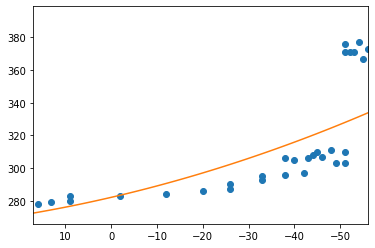

In [13]:
try:
    g = df.groupby('id')

    sid = next(gen)
    order = 2
    df_id = g.get_group(sid)

    # get x and y vectors
    x = df_id.x
    y = df_id.y

    # calculate polynomial
    z, m = np.polyfit(x, y, order, cov=True, rcond =300)
    f = np.poly1d(z)

    # calculate new x's and y's
    x_new = np.linspace(x.iloc[0], x.iloc[-1], 50)
    y_new = f(x_new)

    plt.plot(x,y,'o', x_new, y_new)
    plt.xlim([x.iloc[0]-1, x.iloc[-1] + 1 ])
    plt.show()
except:
    pass

In [14]:
df.describe()

,id,frame,x,y,w,h,x_prev,y_prev,angle,angle_prev,angle_diff,distance,cum_distance
count,5616.000000,5616.000000,5616.000000,5616.000000,5616.000000,5616.00000,5616.000000,5616.000000,5616.000000,5616.000000,5616.000000,5616.000000,5616.000000
mean,176.009972,5827.703882,322.586717,290.629095,46.831909,38.19302,324.217058,290.124822,171.809752,159.002640,44.810802,3.762730,110.314868
std,106.185969,2672.120568,244.123800,83.640453,30.625888,31.10713,243.168252,83.234310,81.912483,89.790816,52.131547,2.267266,96.036881
min,2.000000,1503.000000,-74.000000,183.000000,8.000000,7.00000,-76.000000,183.000000,0.000000,0.000000,0.000000,2.000000,2.000000
25%,84.000000,3472.750000,66.750000,216.000000,27.000000,16.00000,70.750000,216.000000,143.130102,135.000000,5.906141,2.000000,39.446076
50%,176.000000,5963.000000,350.000000,239.000000,39.000000,27.00000,350.000000,239.000000,180.000000,161.565051,26.565051,3.000000,85.338050
75%,261.000000,8165.000000,559.000000,368.000000,56.000000,54.00000,560.000000,367.000000,191.309932,180.000000,60.255119,5.000000,151.006692
max,357.000000,9673.000000,710.000000,533.000000,327.000000,309.00000,710.000000,533.000000,355.236358,357.614056,180.000000,12.206556,569.400374


#### Smooth the data

In [15]:
window = 5
center = False
std = 0.2

def smooth(df):
    df.loc[:,'x'] = df.x.rolling(window=window, win_type='gaussian', center=center).mean(std=std)
    df.loc[:,'y'] = df.y.rolling(window=window, win_type='gaussian', center=center).mean(std=std)
    df = df.dropna()
    return df

df = df.groupby('id').apply(smooth).reset_index(drop=True)

In [16]:
print(len(df))
df.tail()

4863


,id,frame,x,y,w,h,label,x_prev,y_prev,angle,angle_prev,angle_diff,distance,cum_distance
4858,357,9668,353.999993,234.000004,37,19,car,349.0,235.0,180.000000,161.565051,18.434949,2.000000,208.980230
4859,357,9669,349.000011,234.999996,37,19,car,347.0,235.0,225.000000,180.000000,45.000000,9.899495,218.879725
4860,357,9671,346.999981,234.999974,37,19,car,316.0,240.0,170.537678,153.434949,17.102729,12.165525,257.878066
4861,357,9672,339.999892,228.000078,37,19,car,304.0,242.0,153.434949,170.537678,17.102729,2.236068,260.114134
4862,357,9673,304.000127,241.999952,37,19,car,302.0,243.0,206.565051,153.434949,53.130102,2.236068,262.350202


In [17]:
plot_width, plot_height=1200, 650

left = 0
right = df.x.max()
bottom = 0
top = df.y.max()

p = figure(plot_width=plot_width, plot_height=plot_height, x_axis_location="above", x_range=(left, right), y_range=(top, bottom))



# p.y_range.flipped = True

ids = df.id.drop_duplicates()
palatte = sns.color_palette("hls", len(ids))
hex_platte = [matplotlib.colors.to_hex(rgb) for rgb in palatte]
colors = dict(zip(ids, hex_platte))   

# tooltips=[(clm, f'@{clm}') for clm in df.columns]
tooltips=[('id', '@id'),('Frame', '@frame'),('(X, Y)', '(@x, @y)'),('(W, H)', '(@w, @h)'), ('angle', '@angle'), ('distance', '@distance'), ('Label', '@label') ]
                                
hover_tool = HoverTool(tooltips=tooltips,)


for curr_id, curr_df in df.groupby('id'):                
    source = ColumnDataSource(curr_df)
    color = colors[curr_id]
    
    legend = curr_df.label.values[0]#str(curr_id)
    p.circle(x='x', y='y', source=source, legend=legend, color=color, muted_color=color, muted_alpha=0.1, alpha=0.5, muted=True)    
    
    
p.add_tools(hover_tool)
p.legend.click_policy="mute"
show(p)

median_path = _path.parent/'median.jpg'
if median_path.exists():    
    fig, ax = plt.subplots(figsize=(20, 10))
    img=mpimg.imread(str(median_path))
    imgplot = plt.imshow(img, 'gray')
    plt.show()

___

### Pre process before DBSCAN

In [18]:
def _data_to_input(df):
    data = df.reset_index()[['x','y', 'angle', 'id']].dropna() #'diff_x', 'diff_y',
    data.loc[:, 'angle_2'] = data.angle **2
    # data = df[['x','y']].values 
    X = StandardScaler().fit_transform(data.values)
    # X = data.values
    return X, data

In [19]:
X, data = _data_to_input(df)
data.tail()

,x,y,angle,id,angle_2
4858,353.999993,234.000004,180.000000,357,32400.000000
4859,349.000011,234.999996,225.000000,357,50625.000000
4860,346.999981,234.999974,170.537678,357,29083.099547
4861,339.999892,228.000078,153.434949,357,23542.283520
4862,304.000127,241.999952,206.565051,357,42669.120368


### Compute DBSCAN

In [20]:
def compute_db_scan(df, eps, min_samples):
    X, data = _data_to_input(df)
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_    
    
    data.loc[:,'cluster'] = labels
    data.loc[:,'is_core'] = core_samples_mask
    
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
   
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(X, labels))
   
    return db, data

### Plot results

In [21]:
def convert_to_hex(rgba_color) :    
    red = int(rgba_color[0]*255)
    green = int(rgba_color[1]*255)
    blue = int(rgba_color[2]*255)
    return '#{:02x}{:02x}{:02x}'.format(red, green, blue )    

def plot_db_scan(figure, df_xy, color, markersize, label):
    if not len(df_xy):
        return    
    source = ColumnDataSource(df_xy)        
    color=convert_to_hex(color)
    glyph = figure.circle(x='x', y='y', source=source, legend=str(label), color=color, muted_color=color, muted_alpha=0.1, alpha=0.7, size=markersize, line_color='black')    
    glyph.muted = True

In [22]:
EPS = 0.7
MIN_SAMPLES = len(data) *0.015 #40 # Higher value > fewer clusters
print(f'MIN_SAMPLES: {MIN_SAMPLES}')
draw_noise, draw_none_core = False, True

db, data = compute_db_scan(df, eps=EPS, min_samples=MIN_SAMPLES)

labels = data.cluster.unique()
unique_labels = set(labels)

# Black removed and is used for noise instead.
colors = [tuple(plt.cm.Spectral(each)) for each in np.linspace(0, 1, len(unique_labels))]
random.Random(42).shuffle(colors)
colors = dict(zip(labels, colors))

p = figure(plot_width=plot_width, plot_height=plot_height, x_axis_location="above",)
p.y_range.flipped = True

for cluster, df_cluster in data.groupby('cluster'):
    color = colors[cluster]
    if cluster == -1:
        if not draw_noise:
            continue
        # Black used for noise.
        color = [0, 0, 0, 1]

    class_member_mask = (labels == cluster)

    df_core = df_cluster[df_cluster.is_core]    
    title = f'Cluster {cluster}'
    glyph = plot_db_scan(p, df_core, color, 12, title)    

    if draw_none_core:
        df_none_core = df_cluster[~df_cluster.is_core]            
        plot_db_scan(p, df_none_core, color, 6, title)        


hover_tool = HoverTool(tooltips=[[c, f'@{c}'] for c in data.columns],)        
p.add_tools(hover_tool)
p.legend.click_policy="mute"
p.legend.label_text_font_size = "8px"
show(p)

if median_path.exists():    
    fig, ax = plt.subplots(figsize=(20, 10))
    img=mpimg.imread(str(median_path))
    imgplot = plt.imshow(img, 'gray')
    plt.show()

MIN_SAMPLES: 72.945
Estimated number of clusters: 6
Estimated number of noise points: 692
Silhouette Coefficient: 0.357


In [23]:
# df_debug = data.sort_values('id')
# df_debug[df_debug.cluster != -1].iloc[150:200,:]